## Classification results

In [57]:
import pandas as pd

results = []
for i in range(1,12):
    results.append(pd.read_csv(f'data/res_extended/subject_{i}_extended_results.csv'))

results_df = pd.concat(results)

In [58]:
results_df.to_csv(f'all_subjects_classification_extended_results.csv', index=False)

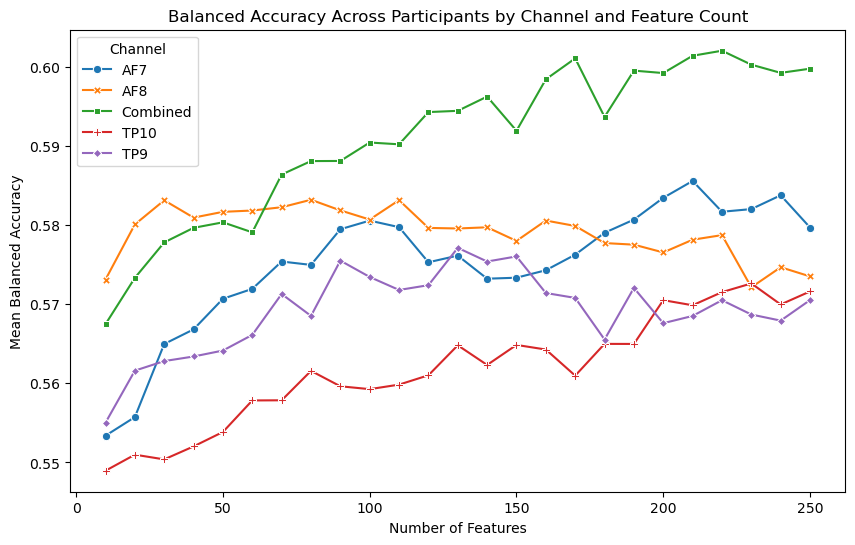

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean Balanced Accuracy
mean_bal_acc = results_df[(results_df['Metric'] == 'test_acc')
 #&(results_df['Subject'].isin([2]))
 #& (~results_df['Subject'].isin([2, 9, 5]))
].groupby(['Channel', 'Num_Features'])['Value'].mean().reset_index()
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_bal_acc, x='Num_Features', y='Value', hue='Channel', style='Channel', markers=True, dashes=False)
plt.title('Balanced Accuracy Across Participants by Channel and Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Mean Balanced Accuracy')
plt.legend(title='Channel')
plt.show()

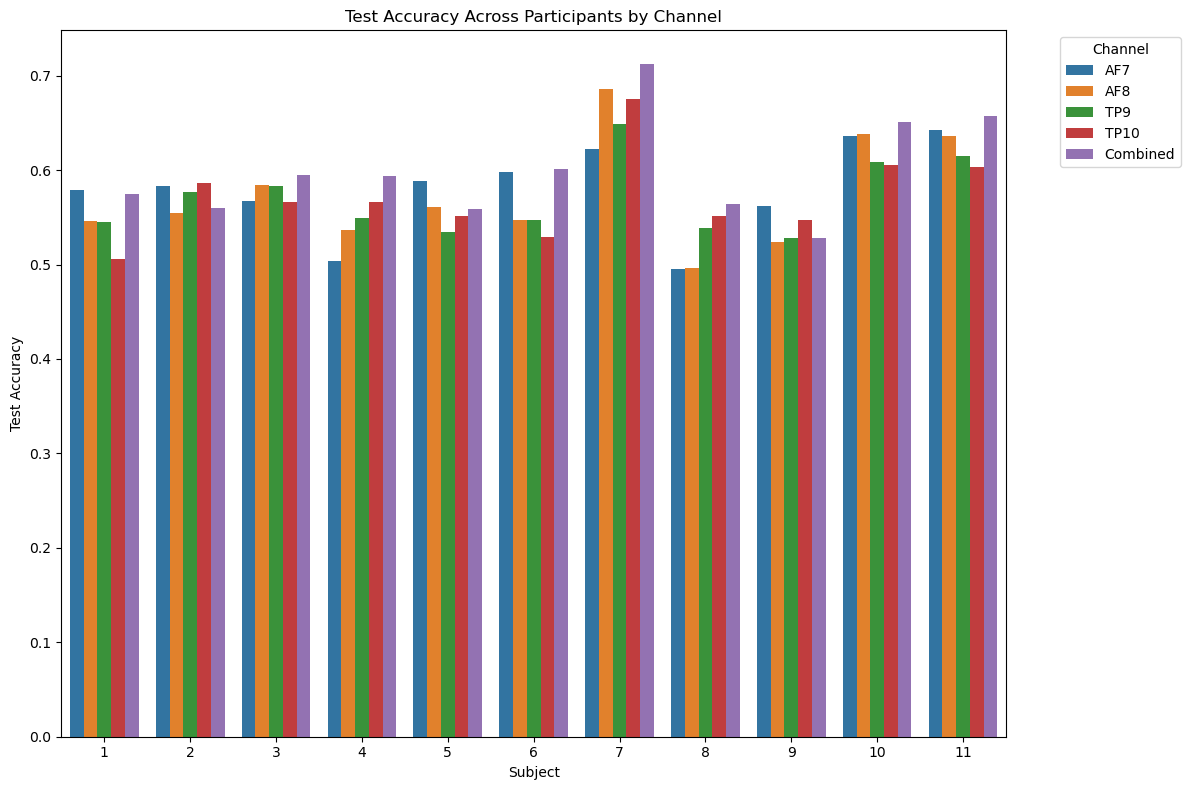

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = results_df[(results_df['Metric'] == 'test_acc') 
& (results_df['Num_Features'] == 250)
]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(data=plot_data, x='Subject', y='Value', hue='Channel', errorbar=None)

# Adding plot title and labels
plt.title('Test Accuracy Across Participants by Channel')
plt.xlabel('Subject')
plt.ylabel('Test Accuracy')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


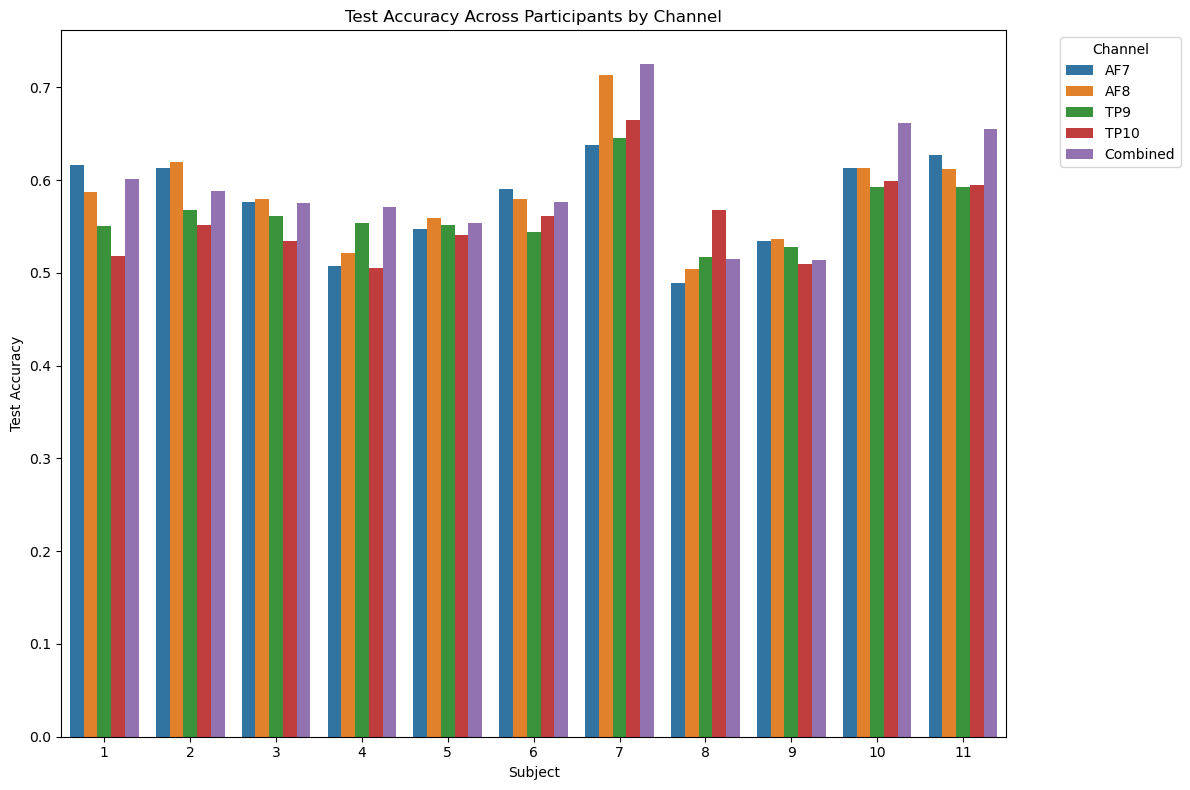

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = results_df[(results_df['Metric'] == 'test_acc') 
& (results_df['Num_Features'] == 250)
]

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
sns.barplot(data=plot_data, x='Subject', y='Value', hue='Channel', errorbar=None)

# Adding plot title and labels
plt.title('Test Accuracy Across Participants by Channel')
plt.xlabel('Subject')
plt.ylabel('Test Accuracy')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


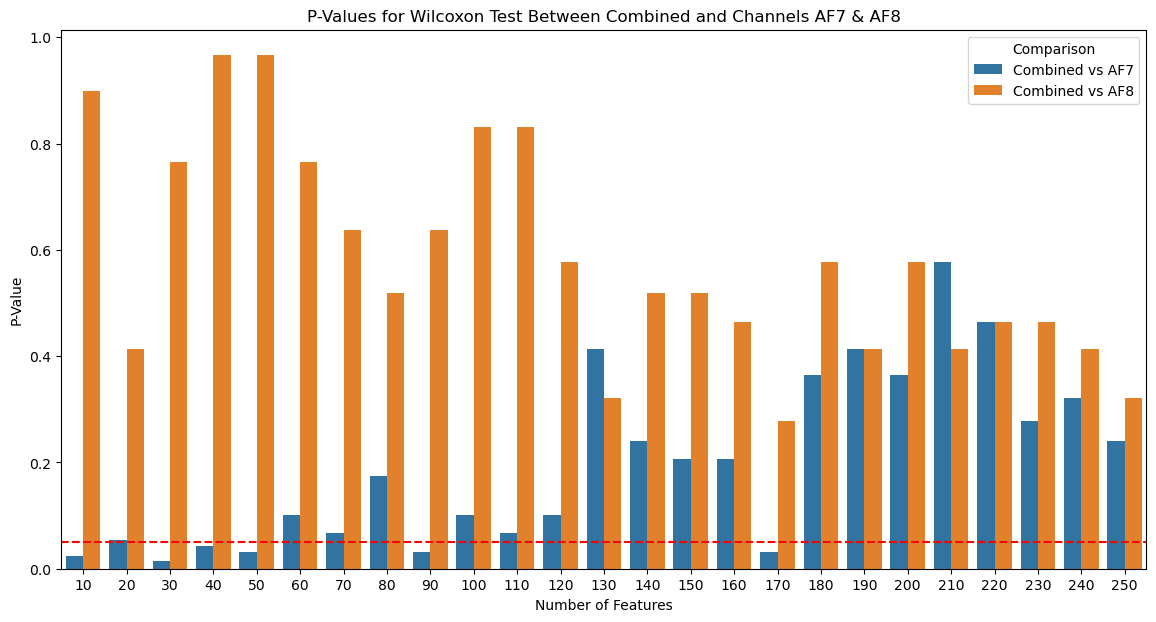

In [10]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
# Filter data for 'test_acc' metric, required channels, and excluding specific subjects
channels = ['AF7', 'AF8', 'Combined']
filtered_data = results_df[(results_df['Metric'] == 'test_acc') & 
                           (results_df['Channel'].isin(channels))
                        #& (~results_df['Subject'].isin([ 5, 9]))
                            ]

# Prepare a dictionary to store results
wilcoxon_results = {'Num_Features': [], 'Comparison': [], 'Statistic': [], 'P-Value': []}

# Group by Num_Features to perform tests
grouped = filtered_data.groupby('Num_Features')

for name, group in grouped:
    combined_data = group[group['Channel'] == 'Combined']['Value']
    af7_data = group[group['Channel'] == 'AF7']['Value']
    af8_data = group[group['Channel'] == 'AF8']['Value']
    
    if len(combined_data) > 1 and len(af7_data) > 1:
        stat, p_value = wilcoxon(combined_data, af7_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF7')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)
        
    if len(combined_data) > 1 and len(af8_data) > 1:
        stat, p_value = wilcoxon(combined_data, af8_data, alternative='two-sided', zero_method='wilcox')
        wilcoxon_results['Num_Features'].append(name)
        wilcoxon_results['Comparison'].append('Combined vs AF8')
        wilcoxon_results['Statistic'].append(stat)
        wilcoxon_results['P-Value'].append(p_value)

# Convert results to DataFrame for easier reading and rename to avoid confusion
significance_df = pd.DataFrame(wilcoxon_results)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=significance_df, x='Num_Features', y='P-Value', hue='Comparison')
plt.title('P-Values for Wilcoxon Test Between Combined and Channels AF7 & AF8')
plt.ylabel('P-Value')
plt.xlabel('Number of Features')
plt.axhline(0.05, color='red', linestyle='--')  # Significance threshold line
plt.legend(title='Comparison')
plt.show()

## Feature importance

In [25]:
import pandas as pd
import numpy as np
from scipy.signal import iirnotch, filtfilt, butter
from IPython.display import clear_output

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, train
#for subject_id in range(1,12):
subject_id = 1

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

for channel in channels:
    # NORMAL
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])
    # ARTIFACTS
    fs = 256
    f0 = 50
    quality_factor = 30
    b, a = iirnotch(f0, quality_factor, fs)
    eeg_data.loc[:, f'{channel}_filt'] = filtfilt(b, a, eeg_data[f'{channel}_normal'])
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_filt']) 
    # BANDPASS
    lowcut = 0.5
    highcut = 50.0
    filter_order = 5
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    eeg_data.loc[:, [f'{channel}_bandpassed']] = filtfilt(b, a, eeg_data[f'{channel}_artif_removed'])

# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

af7_df = combined_features_df.iloc[:, list(range(0, 250)) + [-1]].copy()
af8_df = combined_features_df.iloc[:, list(range(250, 500)) + [-1]].copy()
tp9_df = combined_features_df.iloc[:, list(range(500, 750)) + [-1]].copy()
tp10_df = combined_features_df.iloc[:, list(range(750, combined_features_df.shape[1]-1)) + [-1]].copy()

12/12 Done


In [48]:
#combined_features_df.to_csv(f'subject_1_features.csv', index=False)

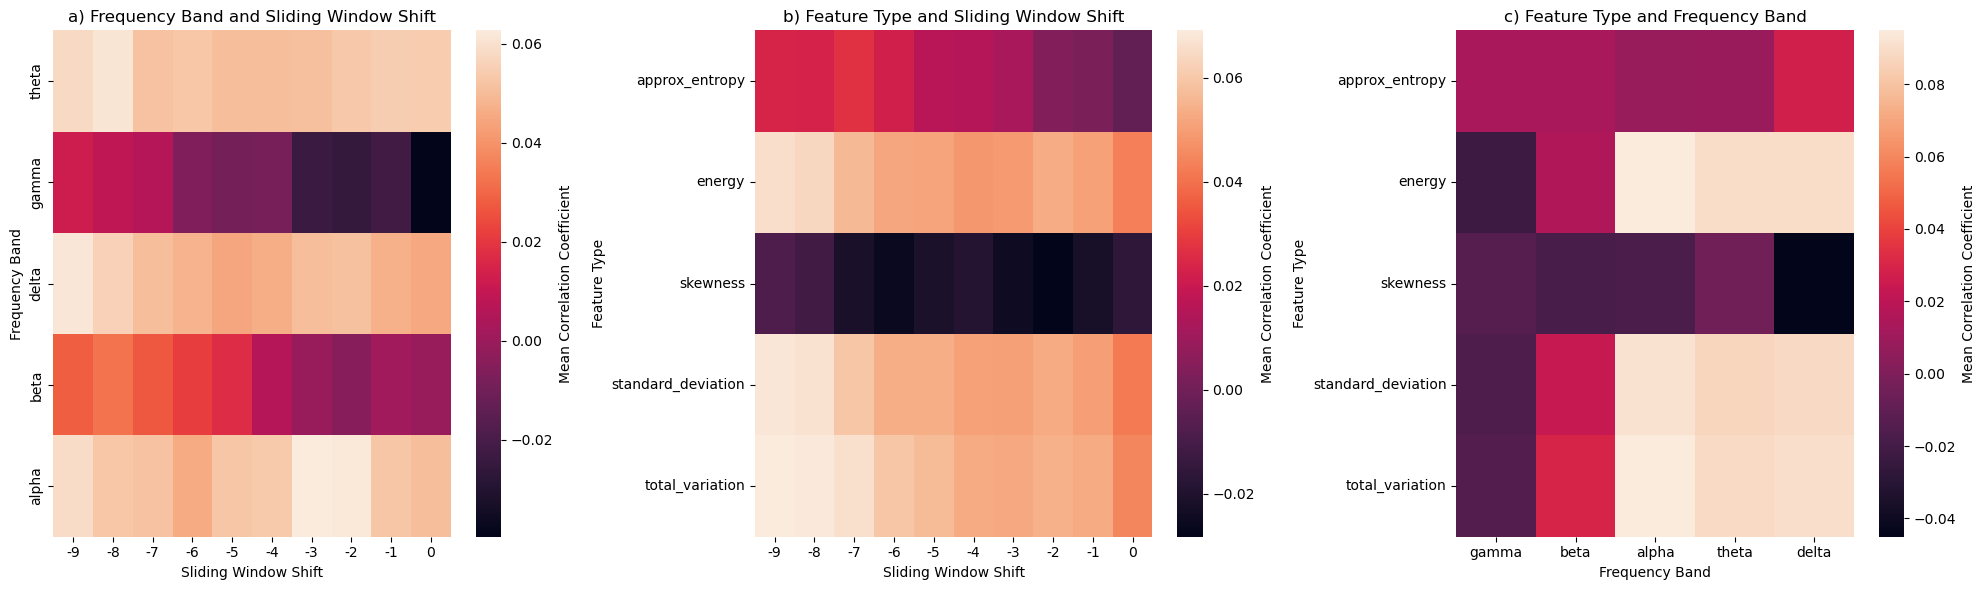

In [55]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_features_df is your dataframe that's already loaded and contains the relevant data
# Extracting information for AF7 sensor, calculating mean correlation coefficients, and reshaping

# Filter columns for AF7 sensor only
af7_columns = [col for col in combined_features_df.columns if col.startswith('AF7')]
af7_data = combined_features_df[af7_columns + ['in_the_zone']]

# Calculate correlation with 'in_the_zone' for each feature
correlations = af7_data.corr()['in_the_zone'].drop('in_the_zone')

# Extract band, feature type, and window information
features_info = []
for col in correlations.index:
    match = re.match(r'AF7_([a-z]+)_(\w+)_win(-?\d+)', col)
    if match:
        band, feature_type, window = match.groups()
        features_info.append((band, feature_type, int(window), correlations[col]))

# Create a DataFrame from the extracted feature information
features_df = pd.DataFrame(features_info, columns=['band', 'feature_type', 'window', 'correlation'])

# Create pivot tables for each heatmap
heatmap_a_data = features_df.pivot_table(index='band', columns='window', values='correlation', aggfunc='mean').sort_index(ascending=False)
heatmap_b_data = features_df.pivot_table(index='feature_type', columns='window', values='correlation', aggfunc='mean')
heatmap_c_data = features_df.pivot_table(index='feature_type', columns='band', values='correlation', aggfunc='mean')

# Order the columns and rows as specified
heatmap_a_data = heatmap_a_data[sorted(heatmap_a_data.columns, key=int)]
heatmap_b_data = heatmap_b_data[sorted(heatmap_b_data.columns, key=int)]
heatmap_c_data = heatmap_c_data[['gamma', 'beta', 'alpha', 'theta', 'delta']]

# Plotting the heatmaps with the desired aspect ratios
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Heatmap (a)
sns.heatmap(heatmap_a_data, ax=axes[0], cbar_kws={'label': 'Mean Correlation Coefficient'})
axes[0].set_title('a) Frequency Band and Sliding Window Shift')
axes[0].set_xlabel('Sliding Window Shift')
axes[0].set_ylabel('Frequency Band')

# Heatmap (b)
sns.heatmap(heatmap_b_data, ax=axes[1], cbar_kws={'label': 'Mean Correlation Coefficient'})
axes[1].set_title('b) Feature Type and Sliding Window Shift')
axes[1].set_xlabel('Sliding Window Shift')
axes[1].set_ylabel('Feature Type')

# Heatmap (c)
sns.heatmap(heatmap_c_data, ax=axes[2], cbar_kws={'label': 'Mean Correlation Coefficient'})
axes[2].set_title('c) Feature Type and Frequency Band')
axes[2].set_xlabel('Frequency Band')
axes[2].set_ylabel('Feature Type')

plt.tight_layout()
plt.show()
